# Computing SHAP values and Jaccard Index Similarities

In [25]:
#! jupyter nbextension enable jupyter-black-master/jupyter-black

#! pip install botocore==1.12.201

#! pip install shap
#! pip install xgboost

In [26]:
import os
import time
import torch
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from urllib.parse import urlparse
import tarfile
import pickle
import shutil

import shap
import xgboost as xgb

import sagemaker
import boto3
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.image_uris import retrieve

import deep_id_pytorch

from lstm_models import *
from att_lstm_models import *
from lstm_utils import *
from xgboost_utils import *
from shap_jacc_utils import *

In [27]:
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. LSTM Dataset and Model Loading

## Constants

In [28]:
nrows = 1e9
min_freq = 1

seq_len = 30

train_data_path = "../../data/toy_dataset/data/{}/train.csv".format(seq_len)
valid_data_path = "../../data/toy_dataset/data/{}/val.csv".format(seq_len)
test_data_path = "../../data/toy_dataset/data/{}/test.csv".format(seq_len)

lstm_shap_features_path = './output/{}/shap/features/lstm_features.pkl'.format(seq_len)
lstm_shap_scores_path = './output/{}/shap/feature-importance/lstm_scores.pkl'.format(seq_len)
lstm_shap_patients_path = './output/{}/shap/feature-importance/lstm_patients.pkl'.format(seq_len)

lstm_att_shap_features_path = './output/{}/shap/features/lstm_att_features.pkl'.format(seq_len)
lstm_att_shap_scores_path = './output/{}/shap/feature-importance/lstm_att_scores.pkl'.format(seq_len)
lstm_att_shap_patients_path = './output/{}/shap/feature-importance/lstm_att_patients.pkl'.format(seq_len)

lstm_model_save_path = './output/{}/lstm/models/model'.format(seq_len)
lstm_results_save_path = "./output/{}/lstm/results/".format(seq_len)

lstm_att_model_save_path = './output/{}/lstm-att/models/model'.format(seq_len)
lstm_att_results_save_path = "./output/{}/lstm-att/results/".format(seq_len)

batch_size = 64

embedding_dim = 8
hidden_dim = 16
nlayers = 1
bidirectional = True
dropout = 0.3

target_colname = 'label'
uid_colname = 'patient_id'
x_inputs = [str(x) for x in range(29, -1, -1)]
target_value = '1'

rev = False

In [29]:
for fp in [lstm_model_save_path, lstm_results_save_path]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f'New directory created: {fp}')
        os.makedirs(os.path.split(fp)[0])
        
for fp in [lstm_att_model_save_path, lstm_att_results_save_path]:
    if not os.path.isdir(os.path.split(fp)[0]):
        print(f'New directory created: {fp}')
        os.makedirs(os.path.split(fp)[0])

print(f"Cuda available: {torch.cuda.is_available()}")
model_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cuda available: True


### Create Vocab and Build Dataset

In [30]:
train_dataset, vocab = build_lstm_dataset(
                                train_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=None,
                                nrows=nrows,
                                rev=rev
                            )
valid_dataset, _ = build_lstm_dataset(
                                valid_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

test_dataset, _ = build_lstm_dataset(
                                test_data_path,
                                min_freq=min_freq,
                                uid_colname="patient_id",
                                target_colname="label",
                                max_len=seq_len,
                                target_value=target_value,
                                vocab=vocab,
                                nrows=nrows,
                                rev=rev
                            )

Building dataset from ../../data/toy_dataset/data/30/train.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/val.csv..
Success!
Building dataset from ../../data/toy_dataset/data/30/test.csv..
Success!


In [31]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

valid_dataloader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)

### LSTM Model Loading and Evaluation

In [32]:
lstm_model = SimpleLSTM(embedding_dim, hidden_dim, vocab, model_device, nlayers=nlayers, dropout=dropout)
lstm_model = lstm_model.cuda()

In [33]:
lstm_model

SimpleLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=32, out_features=1, bias=True)
  (dpt): Dropout(p=0.3, inplace=False)
)

In [34]:
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

In [35]:
lstm_model.load_state_dict(torch.load(lstm_model_save_path))
test_loss, test_auc = epoch_val_lstm(
   lstm_model, test_dataloader, loss_function)#, return_preds=False

print(f"Test Loss: {test_loss:.3f} | Test AUC: {test_auc:.2f}")

Test Loss: 0.320 | Test AUC: 0.91


## 3. LSTM with Attention Model Loading and Evaluation

In [36]:
lstm_att_model = AttLSTM(embedding_dim, hidden_dim, vocab, model_device, nlayers=nlayers, dropout=dropout)
lstm_att_model = lstm_att_model.cuda()

In [37]:
lstm_att_model

AttLSTM(
  (emb_layer): Embedding(32, 8, padding_idx=0)
  (lstm): LSTM(8, 16, batch_first=True, dropout=0.3, bidirectional=True)
  (pred_layer): Linear(in_features=64, out_features=1, bias=True)
  (attn_layer): Linear(in_features=32, out_features=1, bias=True)
  (dpt): Dropout(p=0.3, inplace=False)
  (context_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [38]:
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()

In [39]:
lstm_att_model.load_state_dict(torch.load(lstm_att_model_save_path))
test_loss, test_auc = epoch_val_lstm(
   lstm_att_model, test_dataloader, loss_function)#, return_preds=False

print(f"Test Loss: {test_loss:.3f} | Test AUC: {test_auc:.2f}")

Test Loss: 0.329 | Test AUC: 0.90


## 2. XGBoost Dataset and Model Loading

### Data Preprocessing

In [40]:
x_train_one_hot_path = 'output/{}/xgboost/data/train_one_hot.csv'.format(seq_len)
x_valid_one_hot_path = 'output/{}/xgboost/data/val_one_hot.csv'.format(seq_len)
x_test_one_hot_path = 'output/{}/xgboost/data/test_one_hot.csv'.format(seq_len)

x_train_data_path = 'output/{}/xgboost/data/train.csv'.format(seq_len)
x_valid_data_path = 'output/{}/xgboost/data/val.csv'.format(seq_len)
x_test_data_path = 'output/{}/xgboost/data/test.csv'.format(seq_len)

s3_output_data_dir = 's3://merck-paper-bucket/{}/data'.format(seq_len)

xgb_shap_features_path = './output/{}/shap/features/xgb_features.pkl'.format(seq_len)
xgb_shap_scores_path = './output/{}/shap/feature-importance/xgb_scores.pkl'.format(seq_len)
xgb_shap_patients_path = './output/{}/shap/feature-importance/xgb_patients.pkl'.format(seq_len)

BUCKET = 'merck-paper-bucket'
DATA_PREFIX = '{}/data'.format(seq_len)
MODEL_PREFIX = '{}/xgboost/model'.format(seq_len)
label = 'label'

output_results_path = 'output/{}/xgboost/train/train_results.csv'.format(seq_len)
local_model_dir = 'output/{}/xgboost/models/'
s3_output_path = 's3://{}/{}/output'.format(BUCKET, MODEL_PREFIX)

In [41]:
df = pd.read_csv(train_data_path)
print(df.shape)
df.head()

(18000, 33)


,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2060,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,normal_bmi_U,foot_pain_N,ACL_tear_N,cut_finger_N,headache_N,ACL_tear_N,cold_sore_N,low_salt_diet_U,0,WQT192TZIU
1,1873,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,hay_fever_N,dental_exam_N,cut_finger_N,normal_bmi_U,ACL_tear_N,headache_N,PCI_U,ACE_inhibitors_U,0,EHO31C693C
2,1402,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ankle_sprain_N,ingrown_nail_N,cut_finger_N,ingrown_nail_N,foot_pain_N,cold_sore_N,ARR_A,furosemide_H,1,TREAOF36OI
3,2781,<pad>,<pad>,<pad>,<pad>,myopia_N,dental_exam_N,peanut_allergy_N,ankle_sprain_N,cold_sore_N,...,quad_injury_N,ACL_tear_N,foot_pain_N,quad_injury_N,annual_physical_N,ankle_sprain_N,cold_sore_N,low_salt_diet_U,0,TAF54R2M8X
4,812,<pad>,<pad>,<pad>,<pad>,headache_N,hay_fever_N,cardiac_rehab_U,hay_fever_N,dental_exam_N,...,dental_exam_N,quad_injury_N,ACL_tear_N,cut_finger_N,dental_exam_N,cold_sore_N,foot_pain_N,PCI_U,0,4F38DQWGDM


In [42]:
tokens = lstm_model.vocab._vocab
my_tokens = get_valid_tokens(tokens)

In [43]:
df.head()

,index,29,28,27,26,25,24,23,22,21,...,7,6,5,4,3,2,1,0,label,patient_id
0,2060,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,normal_bmi_U,foot_pain_N,ACL_tear_N,cut_finger_N,headache_N,ACL_tear_N,cold_sore_N,low_salt_diet_U,0,WQT192TZIU
1,1873,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,hay_fever_N,dental_exam_N,cut_finger_N,normal_bmi_U,ACL_tear_N,headache_N,PCI_U,ACE_inhibitors_U,0,EHO31C693C
2,1402,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,<pad>,...,ankle_sprain_N,ingrown_nail_N,cut_finger_N,ingrown_nail_N,foot_pain_N,cold_sore_N,ARR_A,furosemide_H,1,TREAOF36OI
3,2781,<pad>,<pad>,<pad>,<pad>,myopia_N,dental_exam_N,peanut_allergy_N,ankle_sprain_N,cold_sore_N,...,quad_injury_N,ACL_tear_N,foot_pain_N,quad_injury_N,annual_physical_N,ankle_sprain_N,cold_sore_N,low_salt_diet_U,0,TAF54R2M8X
4,812,<pad>,<pad>,<pad>,<pad>,headache_N,hay_fever_N,cardiac_rehab_U,hay_fever_N,dental_exam_N,...,dental_exam_N,quad_injury_N,ACL_tear_N,cut_finger_N,dental_exam_N,cold_sore_N,foot_pain_N,PCI_U,0,4F38DQWGDM


In [44]:
prepare_data(train_data_path, x_train_one_hot_path, x_train_data_path, seq_len, target_colname, my_tokens, s3_output_data_dir)
prepare_data(valid_data_path, x_valid_one_hot_path, x_valid_data_path, seq_len, target_colname, my_tokens, s3_output_data_dir)
prepare_data(test_data_path, x_test_one_hot_path, x_test_data_path, seq_len, target_colname, my_tokens, s3_output_data_dir)

Sucess!
Sucess!
Sucess!


### Model Loading and Evaluation

In [53]:
df_train = pd.read_csv(x_train_one_hot_path)
df_test = pd.read_csv(x_test_one_hot_path)

In [54]:
print(df_train.shape)
df_train.head()

(18000, 32)


,patient_id,backache_N,cold_sore_N,ankle_sprain_N,cut_finger_N,low_salt_diet_U,normal_bmi_U,foot_pain_N,ACL_tear_N,headache_N,...,cardiac_rehab_U,high_creatinine_H,AMI_A,PH_A,CHF_A,pneumonia_H,resistent_hyp_H,apnea_H,tachycardia_H,label
0,WQT192TZIU,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,EHO31C693C,0,0,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,TREAOF36OI,1,1,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,TAF54R2M8X,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4F38DQWGDM,1,1,0,1,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0


In [55]:
print(df_test.shape)
df_test.head()

(6000, 32)


,patient_id,backache_N,cold_sore_N,ankle_sprain_N,cut_finger_N,low_salt_diet_U,normal_bmi_U,foot_pain_N,ACL_tear_N,headache_N,...,cardiac_rehab_U,high_creatinine_H,AMI_A,PH_A,CHF_A,pneumonia_H,resistent_hyp_H,apnea_H,tachycardia_H,label
0,CYJGX2RI08,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,9GNM0PF7IQ,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,Y0I7UN86BT,1,1,1,1,0,1,1,1,1,...,1,0,0,0,0,0,0,0,1,1
3,9QPHAVVA7O,0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,1,0,1,0,1
4,QYG71XZNIE,0,1,1,1,0,0,1,1,1,...,0,0,0,0,0,0,1,0,1,1


In [56]:
X_train = df_train.iloc[:, 1:-1]
X_test = df_test.iloc[:, 1:-1]

In [45]:
df_best = pd.read_csv(output_results_path)
df_best

,class,seq_len,val_auc,best_model_path
0,label,30,0.9027,s3://merck-paper-bucket/30/xgboost/model/outpu...


In [46]:
s3_best_model_path = df_best.iloc[0]['best_model_path']
s3_best_model_path

's3://merck-paper-bucket/30/xgboost/model/output/sagemaker-xgboost-210103-1517-001-e562bbb5/output/model.tar.gz'

In [47]:
#Copy the best model from s3 to local
output_path = copy_model_from_s3(s3_best_model_path, local_model_dir)
#Load the copied model
xgb_model = load_model(output_path)

In [57]:
test_auc = xgb_model.eval(xgb.DMatrix(X_test.values, df_test[target_colname].values))
test_auc

'[0]\teval-auc:0.898667'

## 3. Compute SHAP values

In [71]:
#Constants for LSTM
LSTM_N_BACKGROUND = 500 #Number of background examples
LSTM_NEGATIVE_ONLY = True #Whether to use negative examples as background
LSTM_N_TEST = 64 # Number of examples to compute shap values from

XGB_N_BACKGROUND = 500
XGB_NEGATIVE_ONLY = True
XGB_N_TEST = 64

In [72]:
print('Computing SHAP values for LSTM model...')
lstm_features, lstm_scores, lstm_patient_ids = get_lstm_features_and_shap_scores(
                                              lstm_model, 
                                              train_dataloader, 
                                              test_dataloader, 
                                              seq_len,
                                              lstm_shap_features_path,
                                              lstm_shap_scores_path,
                                              lstm_shap_patients_path,
                                              n_test=LSTM_N_TEST,
                                              n_background=LSTM_N_BACKGROUND,
                                              negative_only=LSTM_NEGATIVE_ONLY)

print('Computing SHAP values for LSTM with Attention model...')
lstm_att_features, lstm_att_scores, lstm_att_patient_ids = get_lstm_features_and_shap_scores(
                                              lstm_att_model, 
                                              train_dataloader, 
                                              test_dataloader, 
                                              seq_len,
                                              lstm_att_shap_features_path,
                                              lstm_att_shap_scores_path,
                                              lstm_att_shap_patients_path,
                                              n_test=LSTM_N_TEST,
                                              n_background=LSTM_N_BACKGROUND,
                                              negative_only=LSTM_NEGATIVE_ONLY)

print('Computing SHAP values for XGB model...')
xgb_features, xgb_scores, xgb_patient_ids = get_xgboost_features_and_shap_scores(
                                                 xgb_model, 
                                                 df_train, 
                                                 df_test,
                                                 xgb_shap_features_path,
                                                 xgb_shap_scores_path,
                                                 xgb_shap_patients_path,
                                                 n_test=XGB_N_TEST,
                                                 n_background=XGB_N_BACKGROUND,
                                                 negative_only=XGB_NEGATIVE_ONLY)
print('Successfully Completed!')

Computing SHAP values for LSTM model...
Computing SHAP values for LSTM with Attention model...
Computing SHAP values for XGB model...
saved ./output/30/shap/features/xgb_features.pkl pickle..
saved ./output/30/shap/feature-importance/xgb_scores.pkl pickle..
saved ./output/30/shap/feature-importance/xgb_patients.pkl pickle..
Successfully Completed!


### Visualize SHAP values for a single example

In [59]:
#Load features, scores & patient ids if necessary
# lstm_features = load_pickle(lstm_shap_features_path)
# lstm_scores = load_pickle(lstm_shap_scores_path)
# lstm_patients = load_pickle(lstm_shap_patients_path)

# lstm_att_features = load_pickle(lstm_att_shap_features_path)
# lstm_att_scores = load_pickle(lstm_att_shap_scores_path)
# lstm_att_patients = load_pickle(lstm_att_shap_patients_path)

# xgb_features = load_pickle(lstm_shap_features_path)
# xgb_scores = load_pickle(lstm_shap_scores_path)
# xgb_patients = load_pickle(xgb_shap_patients_path)

In [84]:
#index of the patient where you get compute shap
idx = 4

In [85]:
#For LSTM Model
lstm_features1 = lstm_features[idx]
lstm_scores1 = lstm_scores[idx]
lstm_patient_id = lstm_patient_ids[idx]
len(lstm_features1), len(lstm_scores1)

df_lstm_shap = pd.DataFrame(np.array([lstm_features1, lstm_scores1]).T, columns=['events', 'shap_vals'])
df_lstm_shap["shap_vals"] = pd.to_numeric(df_lstm_shap["shap_vals"])
print(df_lstm_shap.shape)
df_lstm_shap.head()

(21, 2)


,events,shap_vals
0,foot_pain_N,0.018212
1,annual_physical_N,0.003226
2,peanut_allergy_N,-0.009203
3,resistent_hyp_H,-0.002434
4,ankle_sprain_N,-0.001044


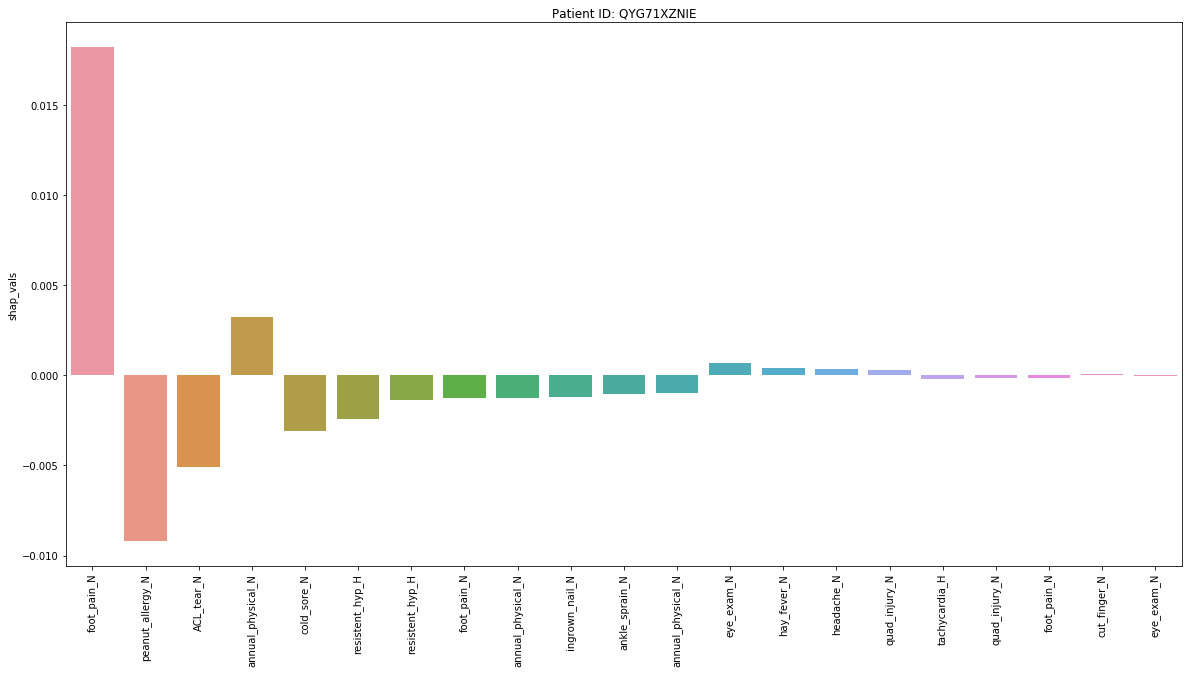

In [86]:
plot_shap_values(df_lstm_shap, lstm_patient_id, sort=True)

In [87]:
#For LSTM+Attention Model
lstm_att_features1 = lstm_att_features[idx]
lstm_att_scores1 = lstm_att_scores[idx]
lstm_att_patient_id = lstm_att_patient_ids[idx]
len(lstm_att_features1), len(lstm_att_scores1)

df_lstm_att_shap = pd.DataFrame(np.array([lstm_att_features1, lstm_att_scores1]).T, columns=['events', 'shap_vals'])
df_lstm_att_shap["shap_vals"] = pd.to_numeric(df_lstm_att_shap["shap_vals"])
print(df_lstm_att_shap.shape)
df_lstm_att_shap.head()

(21, 2)


,events,shap_vals
0,foot_pain_N,0.150785
1,annual_physical_N,0.007657
2,peanut_allergy_N,0.007956
3,resistent_hyp_H,-0.000756
4,ankle_sprain_N,0.001990


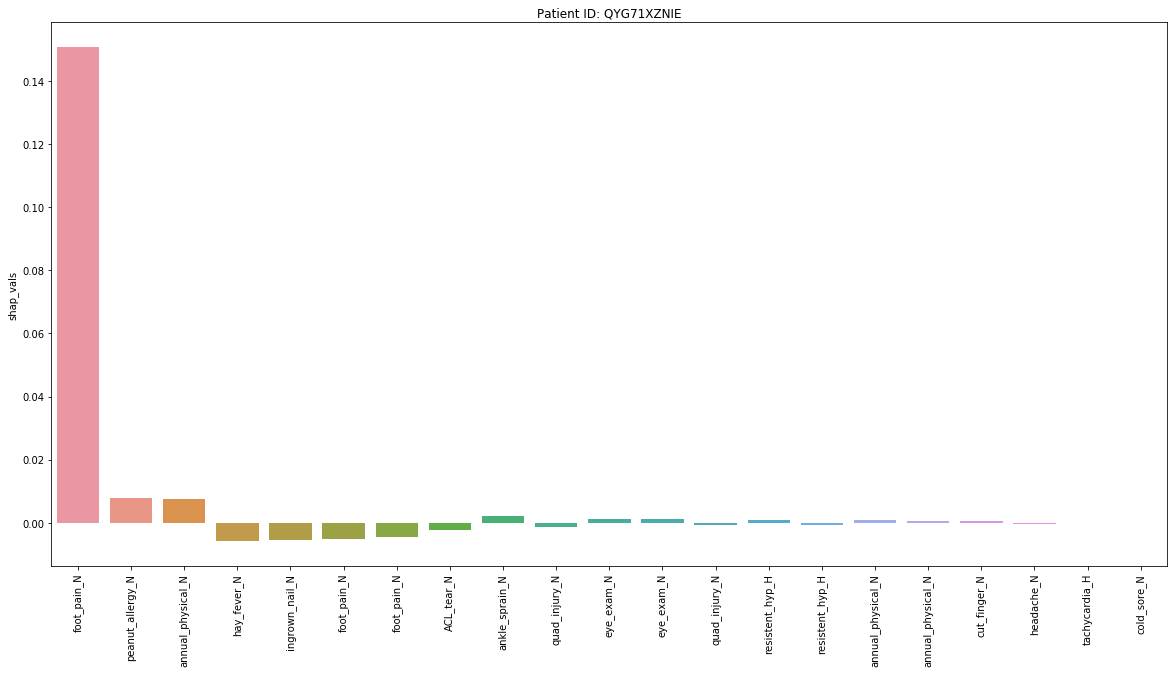

In [88]:
plot_shap_values(df_lstm_att_shap, lstm_att_patient_id, sort=True)

In [89]:
#For XGB Model
xgb_features1 = xgb_features[idx]
xgb_scores1 = xgb_scores[idx]
xgb_patient_id = xgb_patient_ids[idx]
len(xgb_features1), len(xgb_scores1)

df_xgb_shap = pd.DataFrame(np.array([xgb_features1, xgb_scores1]).T, columns=['events', 'shap_vals'])
df_xgb_shap["shap_vals"] = pd.to_numeric(df_xgb_shap["shap_vals"])
print(df_xgb_shap.shape)
df_xgb_shap.head()

(30, 2)


,events,shap_vals
0,backache_N,-0.025256
1,cold_sore_N,0.027374
2,ankle_sprain_N,0.062548
3,cut_finger_N,-0.053494
4,low_salt_diet_U,0.896249


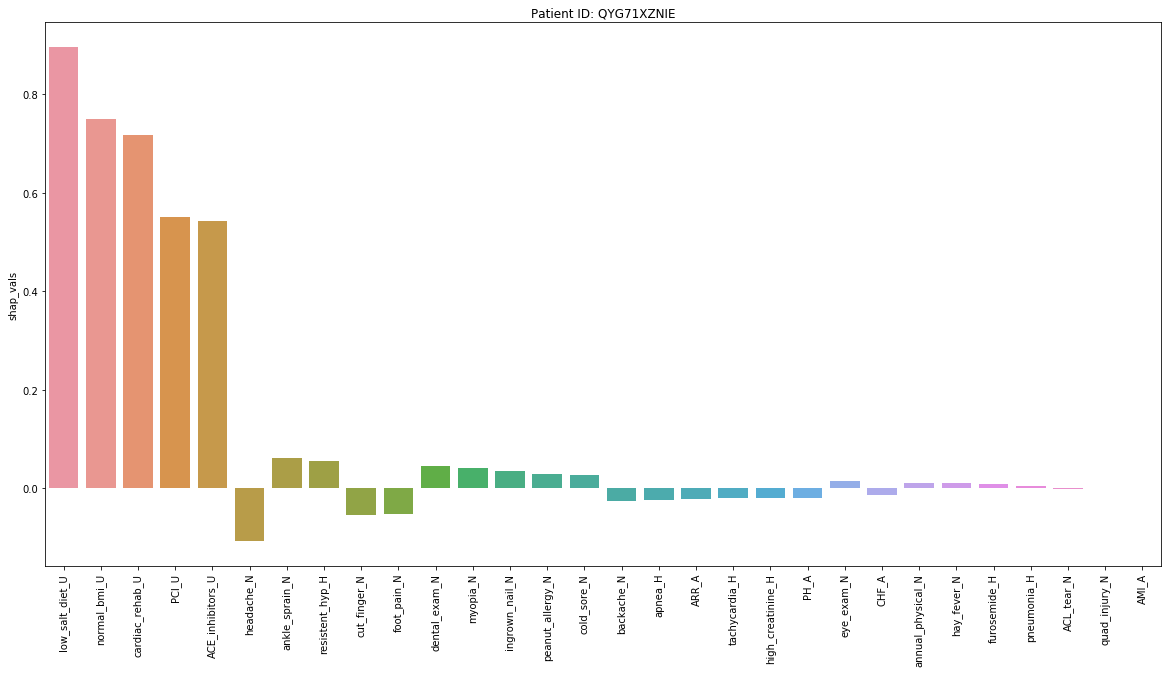

In [90]:
plot_shap_values(df_xgb_shap, xgb_patient_id, sort=True)

## Computing Jaccard Index Similarity b/n Models SHAP Values

In [91]:
k = 5 #Number of top k features
k_list = range(1, 11)
models = ['lstm', 'lstm-att', 'xgb']

In [92]:
lstm_features = load_pickle(lstm_shap_features_path)
lstm_scores = load_pickle(lstm_shap_scores_path)
lstm_features_scores = (lstm_features, lstm_scores)

lstm_att_features = load_pickle(lstm_att_shap_features_path)
lstm_att_scores = load_pickle(lstm_att_shap_scores_path)
lstm_att_features_scores = (lstm_att_features, lstm_att_scores)

xgb_features = load_pickle(xgb_shap_features_path)
xgb_scores = load_pickle(xgb_shap_scores_path)
xgb_features_scores = (xgb_features, xgb_scores)

all_features_scores = [lstm_features_scores, 
                       lstm_att_features_scores, 
                       xgb_features_scores]

In [93]:
len(lstm_features), len(lstm_att_features), len(xgb_features)

(64, 64, 64)

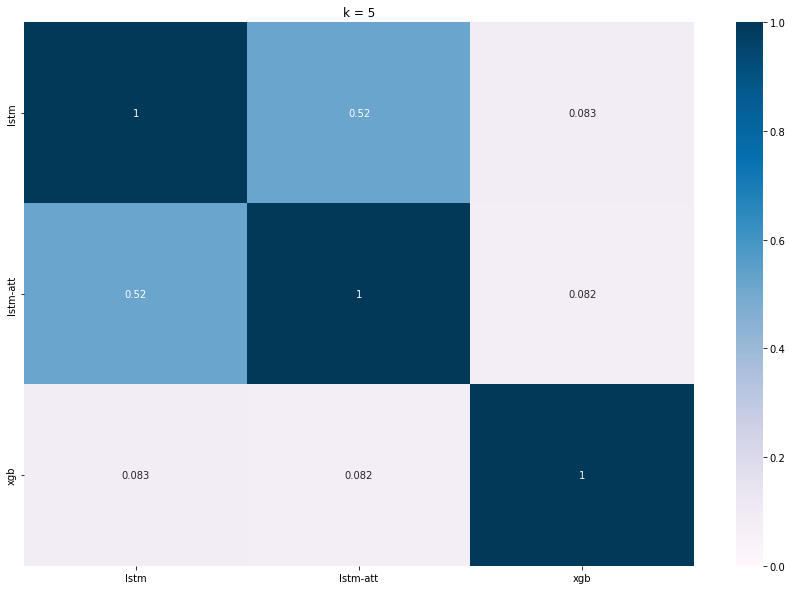

In [94]:
generate_heatmap(all_features_scores, models, k)

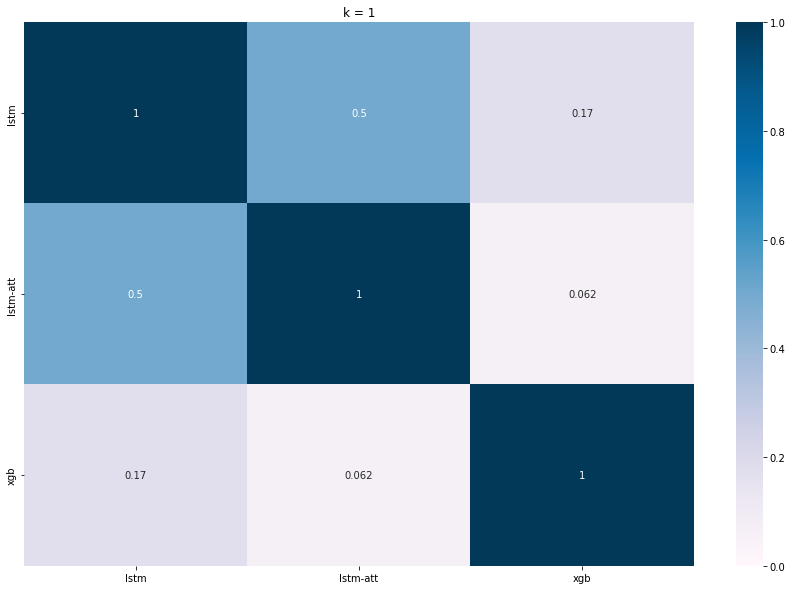

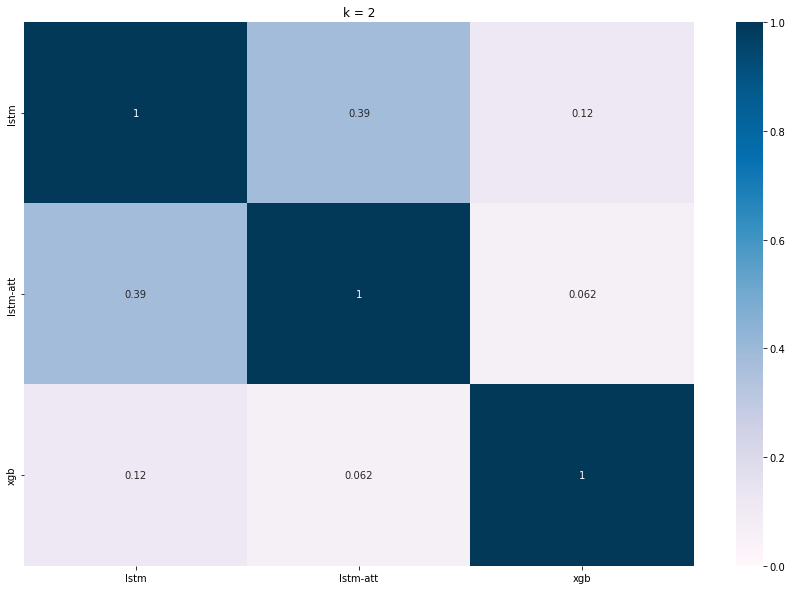

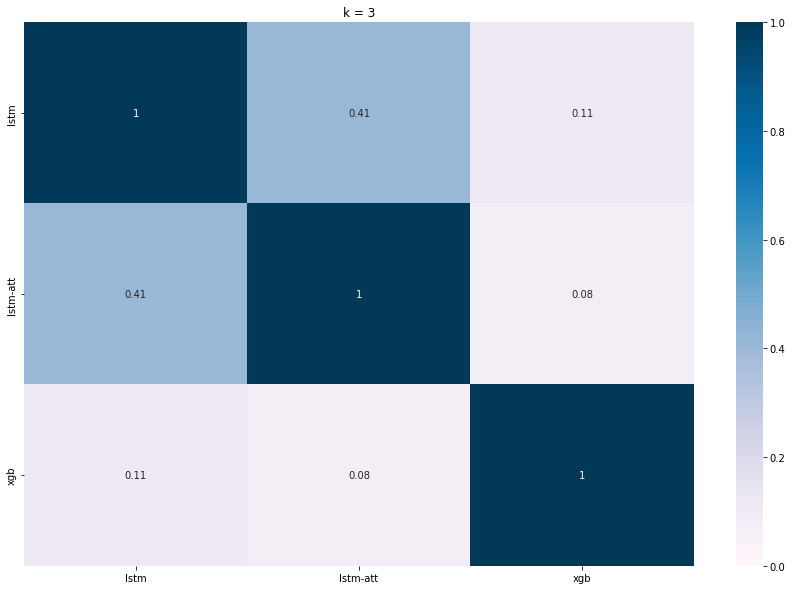

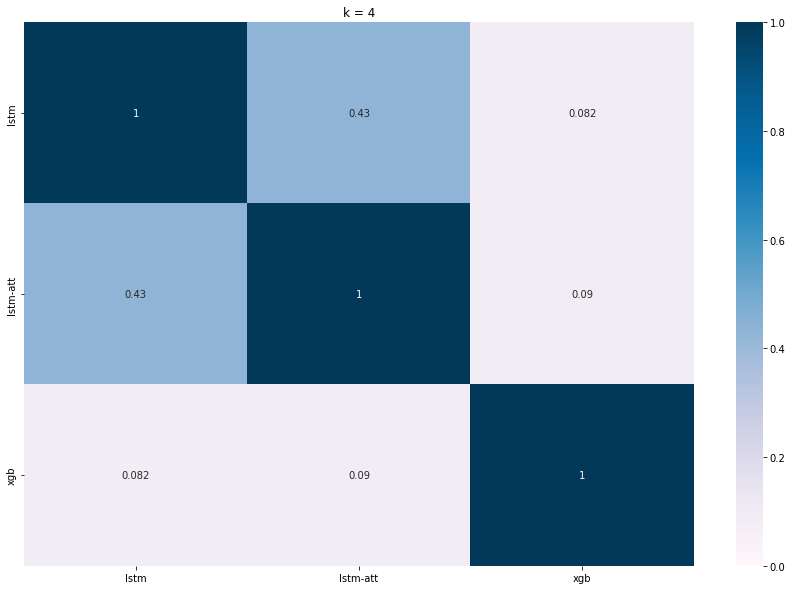

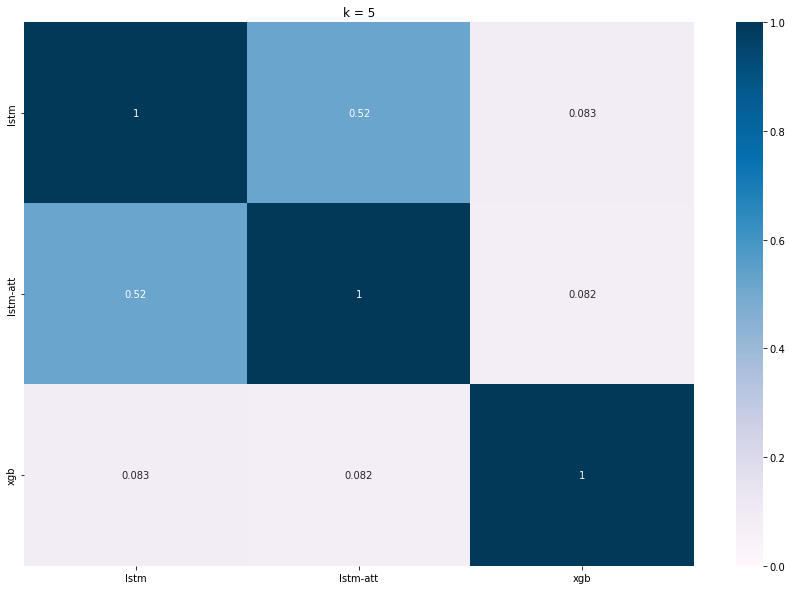

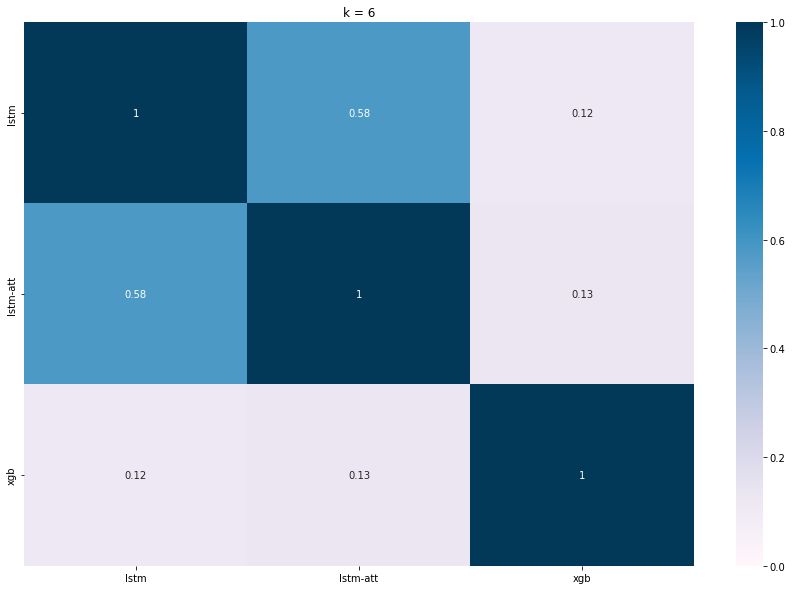

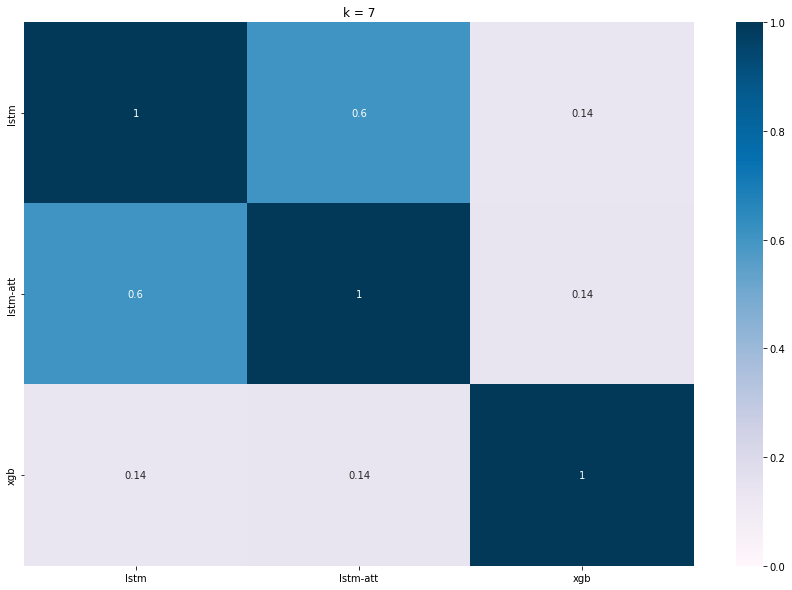

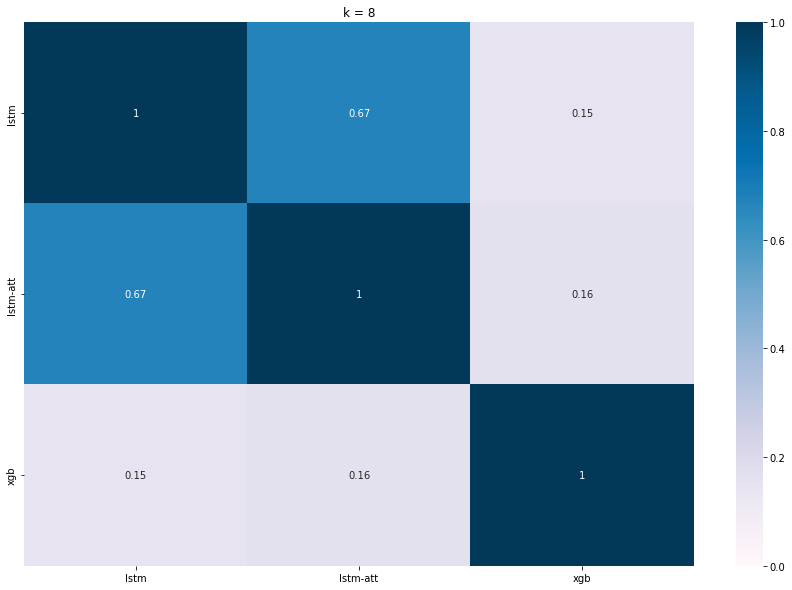

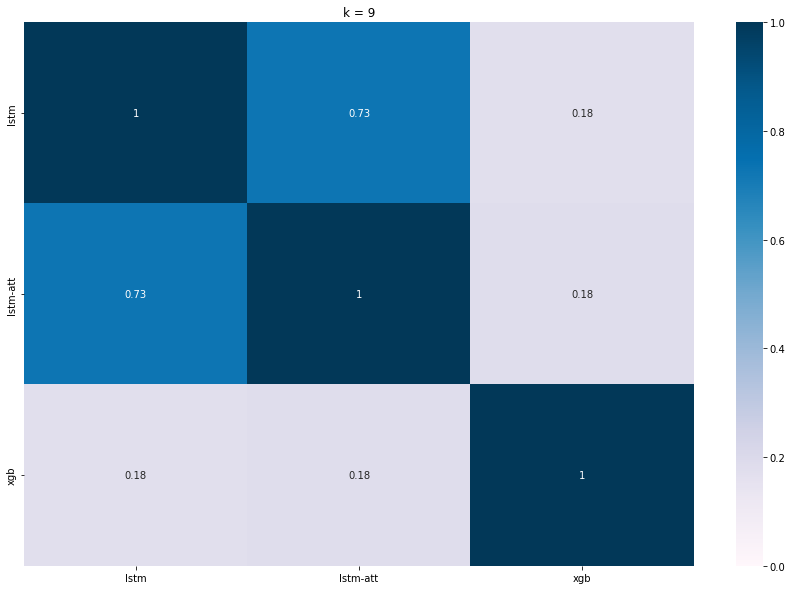

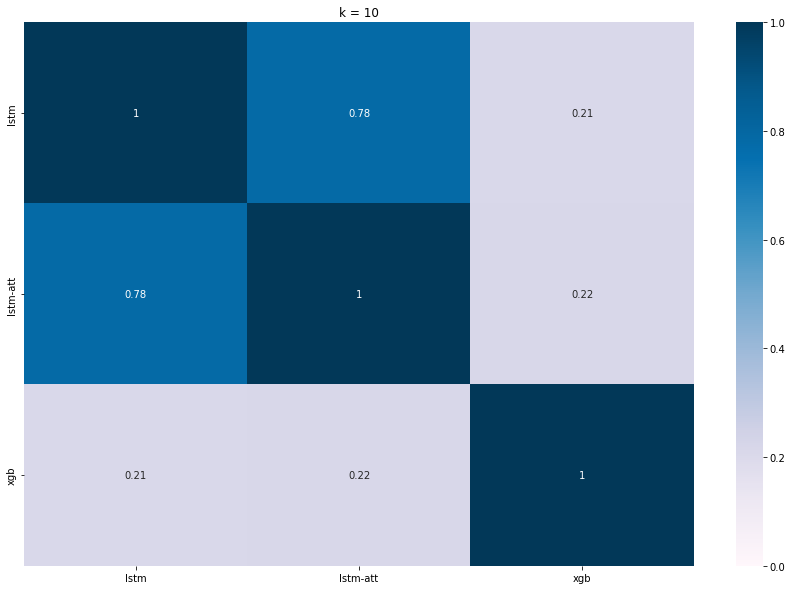

In [95]:
generate_k_heatmaps(all_features_scores, models, k_list)